Classical U-NET debug and launch

In [ ]:
DATA_DIR = '/data/vapyzh/data'

In [2]:
ls $DATA_DIR

pred_valid_template.csv  test/  train/  train_mask/  valid/  valid_mask/


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import cv2

import torch
import torchvision.transforms as transforms

from collections import defaultdict
from tqdm.notebook import tqdm
import time
from IPython.display import clear_output

from torch import nn
from torchsummary import summary 

from PIL import Image
from torch.utils.data import Dataset, random_split
from lib import *

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [9]:
from IPython.display import Image

## Dataset and augmentations


We write dataset, which allows us to use same transformations on image and its mask, let's use albumentations package

In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, data_path, mask_path, transform):
        """
        Args:
            data_path: path to image
            mask_path: path to image mask
            transform: image transformation
        """
        self.data_path = data_path
        self.mask_path = mask_path
        self.transform = transform

        self.file_list = os.listdir(self.data_path)
        self.mask_list = os.listdir(self.mask_path)

        #Sort them for determination.

        self.file_list.sort()
        self.mask_list.sort()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image_filename = self.file_list[idx]
        mask_filename = self.mask_list[idx]
        
        image = cv2.imread(os.path.join(self.data_path, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
        mask = cv2.imread(os.path.join(self.mask_path, mask_filename))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        transformed = self.transform(image=image, mask=mask)
        image = transformed["image"]
        mask = transformed["mask"][:,:,0]
        mask[mask != 0] = 1

        return transformed["image"], mask

As a baseline we use transformations: random rotation, perspective and scaling. These ones obviously can occur on real data, thus they don't affect on our task dramaticaly. Croping might help our model recognise silhouettes better, so we added it.  

In [6]:
train_transformer = A.Compose(
    transforms = [
                  A.HorizontalFlip(p=0.5),
                  A.CoarseDropout(max_holes=2, max_height=26, max_width=26,
                                  min_height=20, min_width=20, mask_fill_value=0, p=0.3),
                  A.Perspective(scale=(0.05, 0.1), p=0.3),
                  A.RandomScale(scale_limit=0.1, p=0.3),
                  A.Rotate(limit=20, p=0.3, border_mode= cv2.BORDER_CONSTANT),
                  A.Resize(240, 320),
                  ToTensorV2(),
                  ],
)

validation_transformer = A.Compose(
    transforms = [
                  A.Resize(240, 320),
                  ToTensorV2(),
                  ],
)

In [7]:
dataset = SegmentationDataset(DATA_DIR + '/train', DATA_DIR + '/train_mask', transform=train_transformer)

## Examples

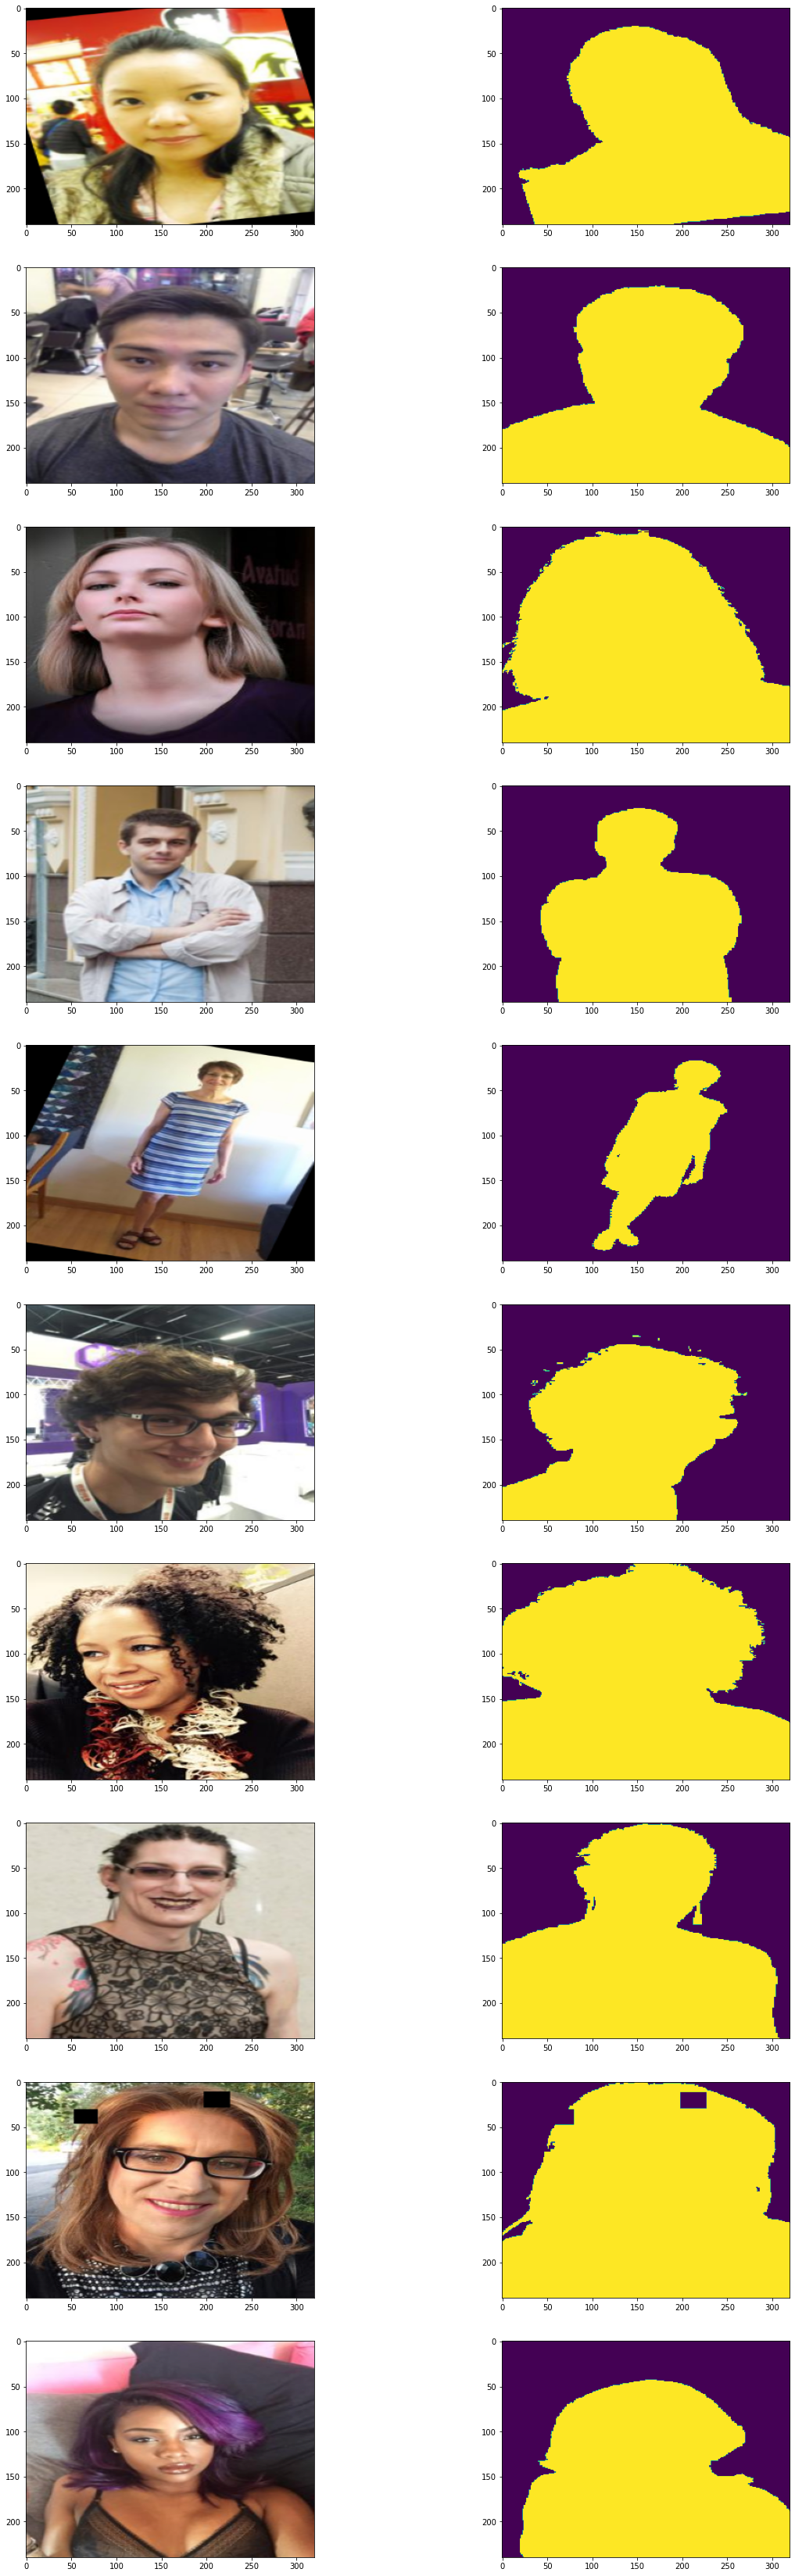

In [8]:
plt.figure(figsize=(20, 60))
for i in range(10):
    img, msk = dataset[i]
    plt.subplot(10, 2, i * 2 + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.subplot(10, 2, i * 2 + 2)
    plt.imshow(msk.squeeze())
plt.show()

Let's see how dice metrics looks and check its correctness

In [9]:
pred = dataset[0][1]
true = dataset[1][1]

In [10]:
intersection = (pred * true)
sumset = pred  + true

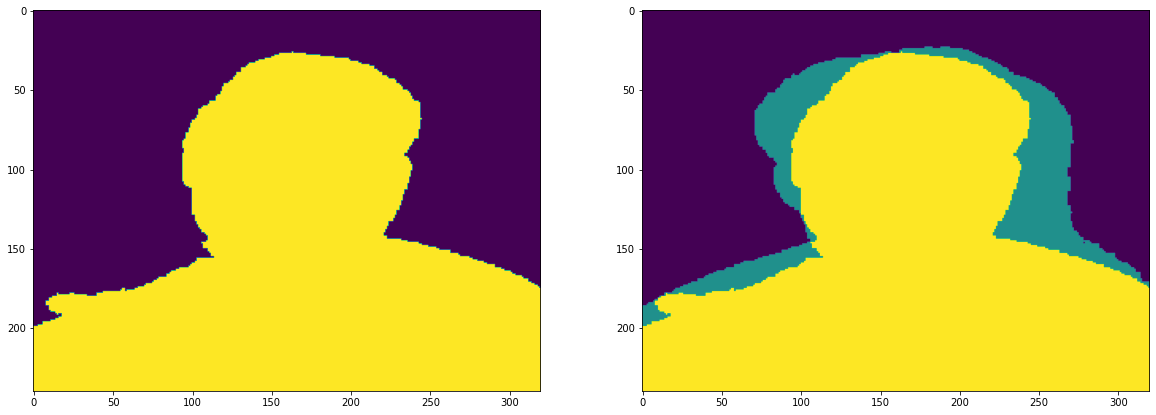

In [11]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(intersection)
plt.subplot(1, 2, 2)
plt.imshow(sumset)

plt.show()

In [12]:
loss = 1 - 2 * torch.sum(intersection) / torch.sum(sumset)

In [13]:
loss

tensor(0.0870)

## U-net model

Original model was proposed for cells segmentation and described in this article:https://arxiv.org/pdf/1505.04597v1.pdf

It was decided to use it as a baseline because of its simplicity and popularity. To simplify calculations of layers size I decided to add padding at every level

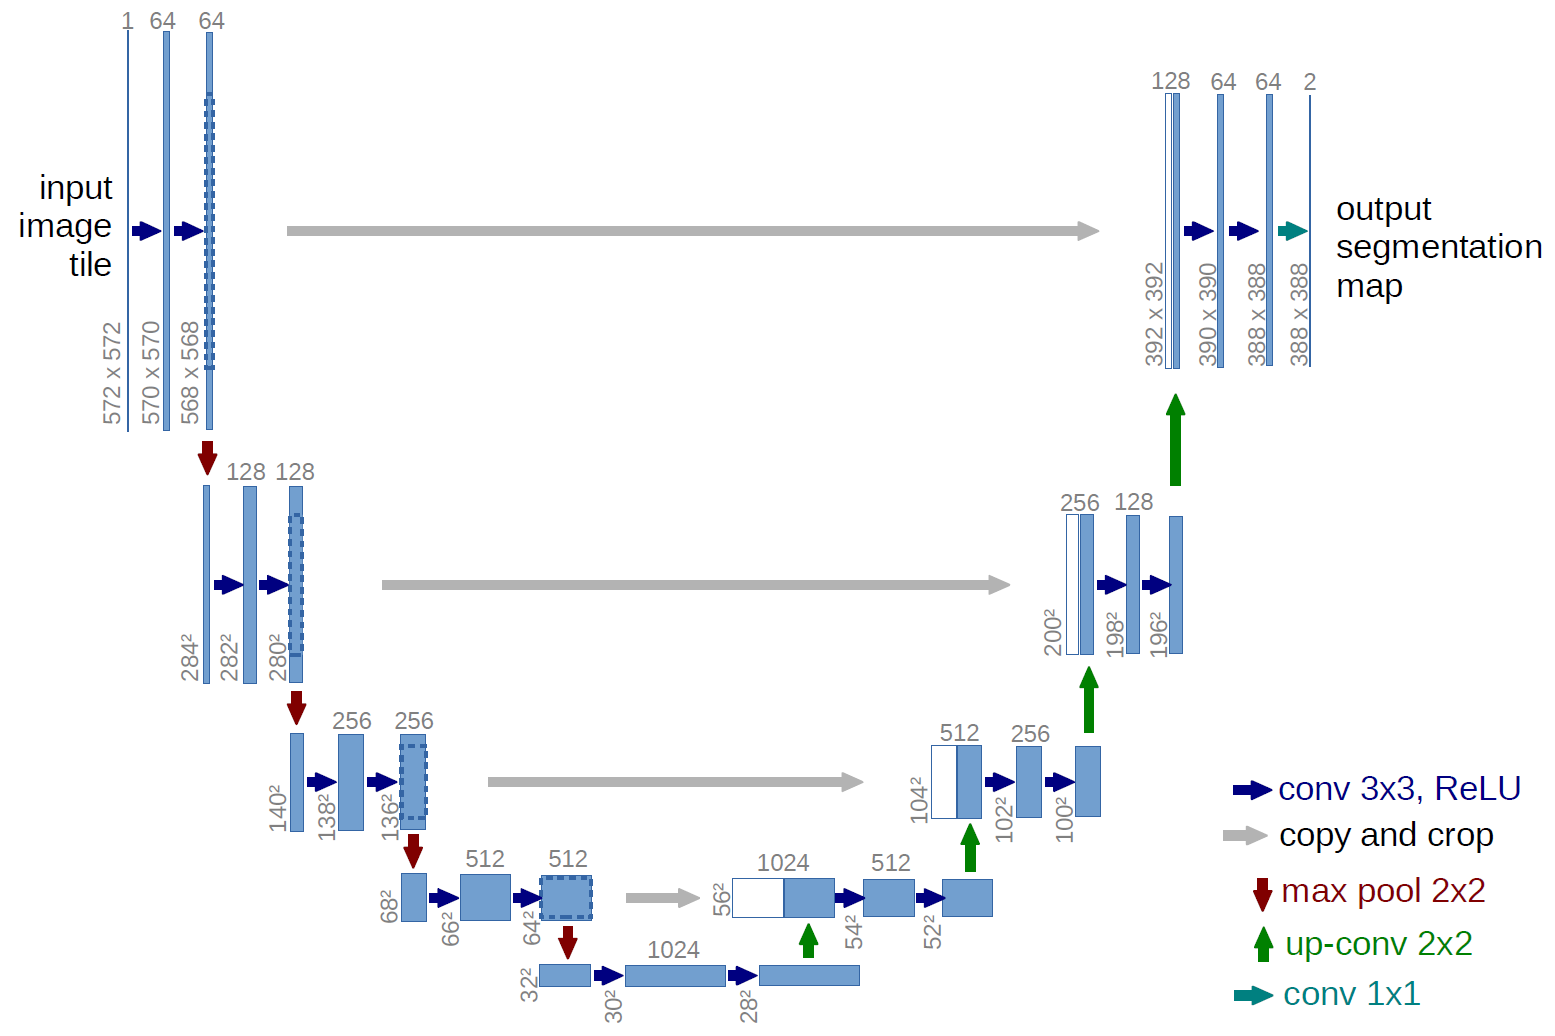

In [15]:
Image(filename = "UNet.png", width=1000)

In [15]:
class Downing_3x3_conv_lvl(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU()
    )
  
  def forward(self, input_):
    return self.seq(input_)


class Uping_3x3_conv_lvl(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU()
    )

  def forward(self, left, right):
    concated = torch.cat([left, right], dim=1)
    return self.seq(concated) 
    


class Unet(nn.Module):
  def __init__(self):
    super().__init__()
    self.left1 = Downing_3x3_conv_lvl(3, 64)
    self.left1to2 = nn.MaxPool2d(2)

    self.left2 = Downing_3x3_conv_lvl(64, 128)
    self.left2to3 = nn.MaxPool2d(2)

    self.left3 = Downing_3x3_conv_lvl(128, 256)
    self.left3to4 = nn.MaxPool2d(2)

    self.left4 = Downing_3x3_conv_lvl(256, 512)
    self.left4to5 = nn.MaxPool2d(2)

    self.mid = Downing_3x3_conv_lvl(512, 1024)
    
    self.right5to4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
    self.right4 = Uping_3x3_conv_lvl(1024, 512)

    self.right4to3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.right3 = Uping_3x3_conv_lvl(512, 256)

    self.right3to2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.right2 = Uping_3x3_conv_lvl(256, 128)

    self.right2to1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.right1 = Uping_3x3_conv_lvl(128, 64)

    self.finish = nn.Conv2d(64, 2, kernel_size=1)
    

  def forward(self, input_):
    level1_cnv = self.left1(input_)
    level2_start = self.left1to2(level1_cnv)

    level2_cnv = self.left2(level2_start)
    level3_start = self.left2to3(level2_cnv)

    level3_cnv = self.left3(level3_start)
    level4_start = self.left3to4(level3_cnv)

    level4_cnv = self.left4(level4_start)
    level5_start = self.left4to5(level4_cnv)

    res = self.mid(level5_start)

    res = self.right5to4(res)
    res = self.right4(level4_cnv, res)

    res = self.right4to3(res)
    res = self.right3(level3_cnv, res)

    res = self.right3to2(res)
    res = self.right2(level2_cnv, res)

    res = self.right2to1(res)
    res = self.right1(level1_cnv, res)

    res = self.finish(res)
    
    return res


In [16]:
device = f"cuda" if torch.cuda.is_available() else "cpu"

In [17]:
model = Unet().to(device)
summary(model, (3, 320, 240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 240]           1,728
              ReLU-2         [-1, 64, 320, 240]               0
            Conv2d-3         [-1, 64, 320, 240]          36,864
              ReLU-4         [-1, 64, 320, 240]               0
Downing_3x3_conv_lvl-5         [-1, 64, 320, 240]               0
         MaxPool2d-6         [-1, 64, 160, 120]               0
            Conv2d-7        [-1, 128, 160, 120]          73,728
              ReLU-8        [-1, 128, 160, 120]               0
            Conv2d-9        [-1, 128, 160, 120]         147,456
             ReLU-10        [-1, 128, 160, 120]               0
Downing_3x3_conv_lvl-11        [-1, 128, 160, 120]               0
        MaxPool2d-12          [-1, 128, 80, 60]               0
           Conv2d-13          [-1, 256, 80, 60]         294,912
             ReLU-14          [-1,

## Pipeline

In [18]:
def plot_learning_curves(history):
    '''
    Function for loss and metrics monitoring
    :param history: (dict)
    dice и loss on training and validation
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('loss', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()


    plt.subplot(1,2,2)
    plt.title('dice', fontsize=15)
    plt.plot(history['dice']['train'], label='train')
    plt.plot(history['dice']['val'], label='val')
    plt.ylabel('dice', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()

    plt.show()

In [19]:
train_dataset = SegmentationDataset(DATA_DIR + '/train', DATA_DIR + '/train_mask', transform=train_transformer)
validation_dataset = SegmentationDataset(DATA_DIR + '/valid', DATA_DIR + '/valid_mask', transform=validation_transformer)

In [20]:
batch_size = 12
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_batch_gen = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.85 ** epoch)

In [22]:
def train_with_aug(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    model_num,
    num_epochs=50,
):
    '''
    Pipeline for model training with monitoring loss and metrics.
    :param model: training model
    :param criterion: loss function
    :param optimizer: optimization method
    :param train_batch_gen: batch generator for process of training 
    :param val_batch_gen: batch generator for process of validation
    :param num_epochs: number of epochs
    :return: trained model
    :return: (dict) accuracy and dice on training and validation "history" of our training
    '''

    history = defaultdict(lambda: defaultdict(list))
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        train_dice = 0
        
        val_loss = 0
        val_dice = 0
        
        start_time = time.time()

        model.train(True)

        for X_batch, y_batch in tqdm(train_batch_gen):
            X_batch = X_batch.float().to(device)
            y_batch = y_batch.long().to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.squeeze().detach().cpu().numpy().argmax(axis=1)
            train_dice += get_dice(y_batch.cpu().numpy(), y_pred) 

        train_loss /= len(train_batch_gen)
        train_dice /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['dice']['train'].append(train_dice)

        scheduler.step()
        
        model.train(False)

        for X_batch, y_batch in tqdm(val_batch_gen):
            X_batch = X_batch.float().to(device)
            y_batch = y_batch.long().to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.squeeze().detach().cpu().numpy().argmax(axis=1)
            val_dice += get_dice(y_batch.cpu().numpy(), y_pred)

        val_loss /= len(val_batch_gen)
        val_dice /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['dice']['val'].append(val_dice)


        clear_output()
        
        #beatiful print time and metrics
        print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
        print(" training loss (in-iteration): \t{:.6f}".format(train_loss))
        print(" validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print(" training dice: \t\t\t{:.2f} %".format(train_dice * 100))
        print(" validation dice: \t\t\t{:.2f} %".format(val_dice * 100))
        
        plot_learning_curves(history)

        X_batch, y_batch = next(iter(val_batch_gen))
        orig = X_batch[0]
        true = y_batch[0]
        logits = model(orig.unsqueeze(0).float().to(device))
        pred = logits.detach().cpu().numpy()
        predicted_mask = pred.argmax(axis=1)

        plt.figure(figsize=(12, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(orig.permute(1, 2, 0), label="orig pic")
        plt.subplot(1, 3, 2)
        plt.imshow(true.squeeze(), label="true mask")
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[0], label="predicted mask")
        plt.show()


    return model, history   

Epoch 50 of 50 took 37.491s
 training loss (in-iteration): 	0.190362
 validation loss (in-iteration): 	0.216332
 training dice: 			93.45 %
 validation dice: 			92.41 %


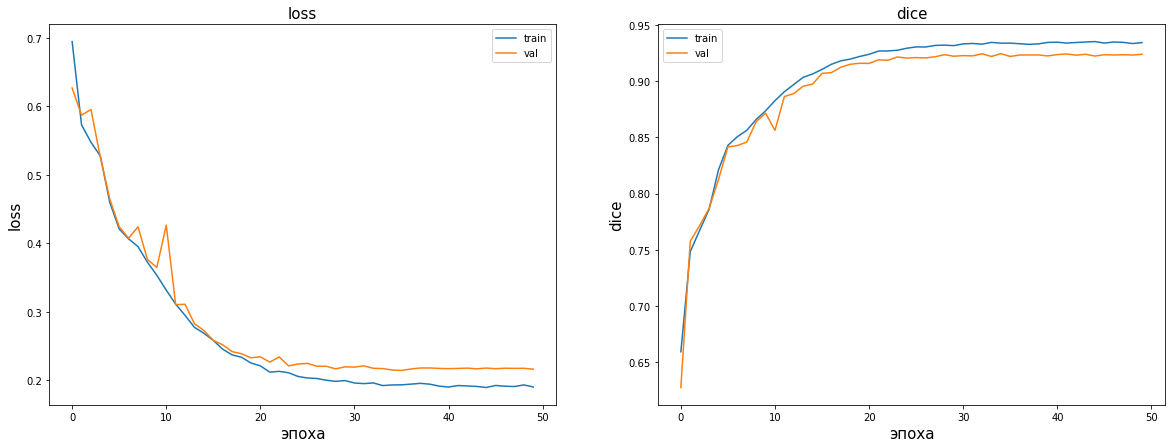

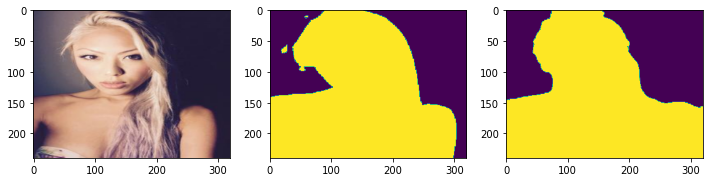

In [23]:
model, history = train_with_aug(model,
                                criterion,
                                optimizer,
                                scheduler,
                                train_batch_gen,
                                val_batch_gen,
                                model_num=1,
                                num_epochs=50)